# Question 6 part 1
In this notebook I solve part 2 of question 6 in which I use the initial condition 

$$
 u(x, 0) = (1 - x)^4(1 + x)\left( \sum_{k=0}^{3} b_k \phi_k(x) + C \right)
$$
"for $L_p = -1$, $L = 1$, $\epsilon = 10^{-3}$, $T = 1$ with $t \in [0, T]$, Legendre polynomials $\phi_k(x) = 1, x, \frac{3}{2}x^2 - \frac{1}{2}, \frac{5}{2}x^3 - \frac{3}{2}x$ and random coefficients $b_k \in [0, 1)$ (uniform distribution and for $k = 0, \dots 3$). A constant $C \geq 0$ is determined (numerically) such that $\sum_{k=0}^{3} b_k \phi_k(x) + C \geq 0$."


In [1]:
import numpy as np
import scipy as sp
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns

### I start by defining the ploblem parameters

In [2]:
### Parameters ###
## domain
Lp = -1
L = 1
##bonduary conditions
u_x0 = 0
u_x1 = 0

## initial condition
def legendre_pol_3(x_vec, b_vec):
    LP_vec = []
    LP0 =  b_vec[0]
    for x in x_vec:
        LP1 = b_vec[1]*x
        LP2 = b_vec[2]*((3.0/2.0)*x*x - 0.5)
        LP3 = b_vec[3]*((5.0/2.0)*(x**3) - (3.0/2.0)*x*x)
        LP_vec.append(LP0 + LP1 + LP2 + LP3)

    min_LP = min(LP_vec)
    if min_LP < 0:
        # the constant C = abs(min_LP), but because I alredy test that min_LP is negative, them I am just subtracting it from LP values
        LP_vec = [x - min_LP for x in LP_vec] 
    return LP_vec

def initial_condition (x_vec, b_vec):
    LP_vec = legendre_pol_3(x_vec, b_vec)
    IC_vec = []
    for x,LP in zip(x_vec, LP_vec):
        IC_vec.append(((1 - x)**4)*(1+x)*LP)
    return IC_vec
 
## equation parameters
a = 1
epsilon = 1e-3

## max t
T_max = 1


##run parameters
J = 40
delta_x = (L- Lp)/float(J)

x_values = []
for j in range(J+1):
    x = Lp + j*delta_x
    x_values.append(x)



### Implementation of the $\Theta$--method

In [3]:
def Un1_theta_method (Un_vec, delta_t, delta_x, theta = 1/2,a = 1,epsilon = 1e-3):
    m = len(Un_vec) - 2
    A = np.zeros((m,m))
    b = np.zeros((m,1))
    
    mu = delta_t/(delta_x*delta_x)
    nu = delta_t/delta_x
    
    ##first term k = 0, j = 1
    A[0,0] = 1.0 + (theta*nu*a) + (2.0*theta*epsilon*mu)
    A[0,1] = -theta*(nu*a + epsilon*mu)

    b[0] = (1 - (1-theta)*(nu*a + 2.0*epsilon*mu))*Un_vec[1] +  (1-theta)*(epsilon*mu)*Un_vec[0]  +  (1-theta)*( nu*a + epsilon*mu)*Un_vec[2]

    ##midle_terms k = [1,m-2] j = k + 1
    for k in range(m - 1):
        j = k+1
        A[k,k] =  1.0 + (theta*nu*a) + (2.0*theta*epsilon*mu)
        A[k,k+1] = -theta*(nu*a + epsilon*mu)
        A[k,k-1] = -theta*(epsilon*mu)
        
        b[k] =  (1 - (1-theta)*(nu*a + 2.0*epsilon*mu))*Un_vec[j] +  (1-theta)*(epsilon*mu)*Un_vec[j-1]  +  (1-theta)*( nu*a + epsilon*mu)*Un_vec[j+1]

    ##last term k = m-1, j = m
    A[m-1,m-1] = 1.0 + (theta*nu*a) + (2.0*theta*epsilon*mu)
    A[m-1,m-2] = -theta*(epsilon*mu)

    j = m
    b[m-1] =  (1 - (1-theta)*(nu*a + 2.0*epsilon*mu))*Un_vec[j] +  (1-theta)*(epsilon*mu)*Un_vec[j-1]  +  (1-theta)*( nu*a + epsilon*mu)*Un_vec[j+1]

    Un1= np.linalg.solve(A,b)
    Un1 = np.insert(Un1, 0, 0)
    Un1 = np.append(Un1, 0)
    

    return Un1

### Here I will plot the solution



[0.6229016948897019, 0.7417869892607294, 0.7951935655656966, 0.9424502837770503]


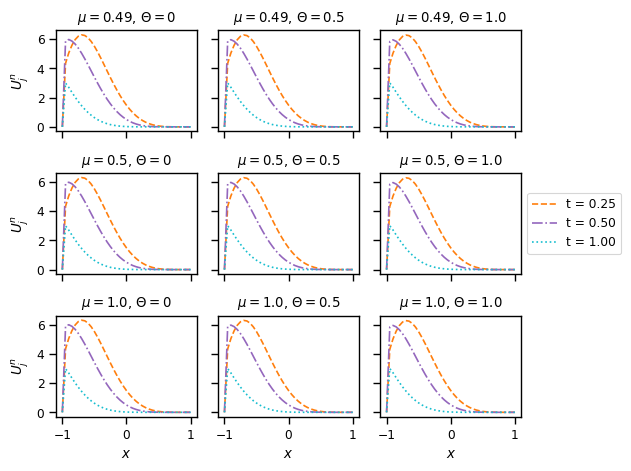

In [7]:
sns.set_context("paper")

h_plot = 3
v_plot = 3
plot_widt = 7
fig, ax = plt.subplots(v_plot, h_plot, sharex=True, sharey=True) #figsize=(plot_widt, plot_widt*v_plot/h_plot)

max_time_vec = [0.25,0.5,1]
mu_vec = [0.49, 0.5, 1.0]
theta_vec = [0,0.5,1.0]
markers_vec = ['o', "*", ">", "+"]
line_vec= ['dashed', 'dashdot', 'dotted']
colours = sns.color_palette()
colour_index = [1,4,9]
random.seed(5)
b_vec = [random.random() for _ in range(4)]
for w in range (v_plot):
    mu = mu_vec[w]
    for i in range(h_plot):
        theta = theta_vec[i]
        delta_t = mu*delta_x*delta_x
        #calculate the initial condition U0 when t = 0
        t = 0
        x_values = [] 
        for j in range(J+1): 
            x = Lp + j*delta_x
            x_values.append(x)
        Un = initial_condition (x_values, b_vec)
        
        m_index = 0
        for t_lim in max_time_vec:
             while t < t_lim:
                 t = t + delta_t
                 Un1 = Un1_theta_method (Un, delta_t, delta_x, theta =theta )
                 Un = Un1
             sns.lineplot(x=x_values, y=Un1, 
                          # marker=markers_vec[m_index], 
                          # markersize = 7,
                          label = f"t = {t:.2f}", color = colours[colour_index[m_index]],
                          linestyle = line_vec[m_index],
                          ax = ax[w,i])
             ax[w,i].set_title(r'$\mu = $' + str(mu) + r', $\Theta = $' + str(theta))
             if (w == 1 and i == 2):
                 ax[w,i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
             else:     
                 ax[w,i].legend([], [], frameon=False)
             m_index = m_index + 1
        if w == v_plot - 1:
            ax[w,i].set_xlabel(r"$x$")
        if i == 0:
            ax[w,i].set_ylabel(r"$U_j^{n}$")


# plt.legend( loc='upper center',            
#            bbox_to_anchor=(-1, -0.4), 
#            borderaxespad=0, ncol=4, 
#            )

print(b_vec)
plt.tight_layout()
plt.savefig('images/Question6-legendre_IC.png', dpi = 500, bbox_inches = 'tight') #facecolor='white'

[0.6229016948897019, 0.7417869892607294, 0.7951935655656966, 0.9424502837770503]


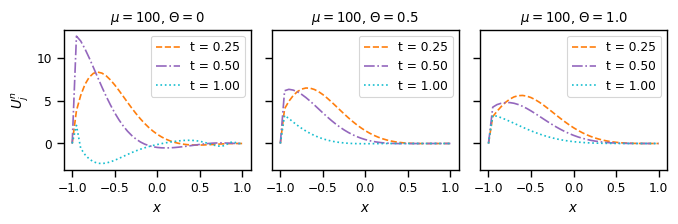

In [33]:
sns.set_context("paper")

h_plot = 3
v_plot = 1
plot_widt = 7
fig, ax = plt.subplots(v_plot, h_plot, sharex=True, sharey=True,figsize=(plot_widt, plot_widt*v_plot/h_plot)) #figsize=(plot_widt, plot_widt*v_plot/h_plot)

max_time_vec = [0.25,0.5,1]
# mu_vec = [499]
theta_vec = [0,0.5,1.0]
markers_vec = ['o', "*", ">", "+"]
line_vec= ['dashed', 'dashdot', 'dotted']
colours = sns.color_palette()
colour_index = [1,4,9]
random.seed(5)
b_vec = [random.random() for _ in range(4)]
mu = 100
delta_t = mu*delta_x*delta_x
for i in range(h_plot):
    theta = theta_vec[i]
    
    #calculate the initial condition U0 when t = 0
    t = 0
    x_values = [] 
    for j in range(J+1): 
        x = Lp + j*delta_x
        x_values.append(x)
    Un = initial_condition (x_values, b_vec)
    
    m_index = 0
    for t_lim in max_time_vec:
        while t < t_lim:
            t = t + delta_t
            Un1 = Un1_theta_method (Un, delta_t, delta_x, theta =theta )
            Un = Un1
        sns.lineplot(x=x_values, y=Un1, 
                     # marker=markers_vec[m_index], 
                     # markersize = 7,
                     label = f"t = {t:.2f}", color = colours[colour_index[m_index]],
                     linestyle = line_vec[m_index],
                     ax = ax[i])
        m_index = m_index + 1
        ax[i].set_title(r'$\mu = $' + str(mu) + r', $\Theta = $' + str(theta))
        ax[i].set_xlabel(r"$x$")
        
ax[0].set_ylabel(r"$U_j^{n}$")


        
print(b_vec)
plt.tight_layout()
plt.savefig('images/Question6-legendre_IC_big_mu.png', dpi = 500, bbox_inches = 'tight') #facecolor='white'

[0.23796462709189137, 0.5442292252959519, 0.36995516654807925, 0.6039200385961945]


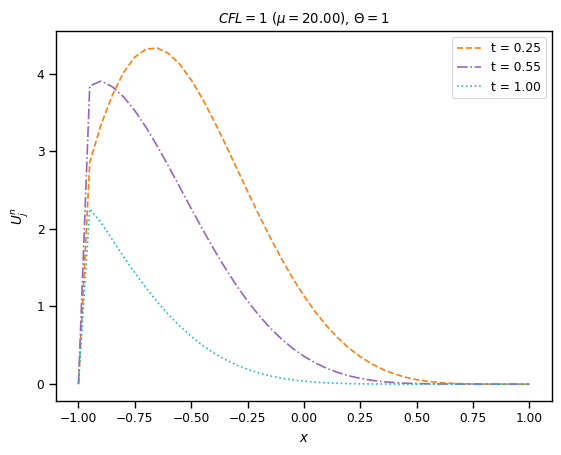

In [8]:
sns.set_context("paper")

h_plot = 1
v_plot = 1
plot_widt = 7
fig, ax = plt.subplots(v_plot, h_plot, sharex=True, sharey=True) #figsize=(plot_widt, plot_widt*v_plot/h_plot)

max_time_vec = [0.25,0.5,1]
CFL = 1
theta = 1
markers_vec = ['o', "*", ">", "+"]
line_vec= ['dashed', 'dashdot', 'dotted']
colours = sns.color_palette()
colour_index = [1,4,9]
random.seed(3)
b_vec = [random.random() for _ in range(4)]

delta_t = CFL*delta_x/a
mu = delta_t/(delta_x*delta_x)
#calculate the initial condition U0 when t = 0
t = 0
x_values = [] 
for j in range(J+1): 
    x = Lp + j*delta_x
    x_values.append(x)
Un = initial_condition (x_values, b_vec)

m_index = 0
for t_lim in max_time_vec:
    while t < t_lim:
        t = t + delta_t
        Un1 = Un1_theta_method (Un, delta_t, delta_x, theta =theta )
        Un = Un1
    sns.lineplot(x=x_values, y=Un1, 
                 # marker=markers_vec[m_index], 
                 # markersize = 7,
                 label = f"t = {t:.2f}", color = colours[colour_index[m_index]],
                 linestyle = line_vec[m_index],)
    ax.set_title(r'$CFL = $' + str(CFL) + r' ($\mu = $' + f'{mu:.2f})'  + r', $\Theta = $' + str(theta))
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$U_j^{n}$")
    m_index = m_index + 1

print(b_vec)
# plt.tight_layout()
plt.savefig('images/Question6-legendre_IC_CFL1_theta1.png', dpi = 500, bbox_inches = 'tight') #facecolor='white'